<a href="https://colab.research.google.com/github/alfredamboka/FinalYearProject/blob/main/RandomforestCropandLandMapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forest Model for Crop Type and Land Classification

> Using RandomForest Classifier for crop type mapping with data from Google Earth Engine.

- toc: true
- badges: true
- author: Drew Bollinger, Zhuang-Fang Yi, Alex Mandel
- comments: false
- hide: false
- sticky_rank: 5

### Setup Notebook

In [ ]:
# Requirements, will skip if already installed
%pip install geopandas rasterio rasterstats shapely
%pip install folium earthengine-api
%pip install scikit-learn
%pip install treeinterpreter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 11.2 MB/s eta 0:00:00


In [ ]:
from os import path as op
import pickle

import geopandas as gpd
import shapely as shp
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.features import rasterize
from rasterstats.io import bounds_window
import rasterstats
import folium

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from treeinterpreter import treeinterpreter as ti

### Connect Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:

# An example is in https://developmentseed.org/sat-ml-training/GettingStarted#Explore-your-drive
my_root_dir = "/content/drive/My Drive/Colab Notebooks/Data"

In [ ]:

# Athenticate to your GEE account.
# !earthengine authenticate

import ee
# ee.Initialize()

## Label data preparation

We will be using an already prepared training dataset that consists of polygons of each land use classification. These polygons were prepared by people using GIS digitizing methods (QGIS, ArcGIS, JOSM) with satellite imagery to trace over.



In [ ]:
# read in training data polygons that created as geojson.

training_data = '/content/drive/MyDrive/Colab Notebooks/Data/Bura_Training_Samples.geojson'
training_vectors = gpd.read_file(training_data)

# make a bounding box and centroid for mapping
bbox = training_vectors.total_bounds


# show the 1st 5 lines
training_vectors.head()

,id,Class,geometry
0,1_1_1_1_1_1_0,0,POINT (39.85684 -1.08956)
1,1_1_1_1_1_1_1,0,POINT (39.85877 -1.09077)
2,1_1_1_1_1_1_2,0,POINT (39.85895 -1.09120)
3,1_1_1_1_1_1_3,0,POINT (39.85779 -1.09096)
4,1_1_1_1_1_1_4,0,POINT (39.83213 -1.12709)


## Reading imagery from Google Earth Engine (GEE)

For this example we will be using Google Earth Engine to select and filter Satellite imagery that we will classify with the training data.

### Search GEE Data

We will now search for Sentinel 2 imagery, a multispectral satellite with ~10m resolution and repeat coverage every 5 days.

Filters will include selecting bands, a date range, and only imagery within a defined Area of Interest (AOI).

In [ ]:

aoi = ee.FeatureCollection('projects/project5yr/assets/BoundBox').geometry()
band_sel = ('B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'QA60')

# sentinel_scenes = ee.ImageCollection("COPERNICUS/S2")\
#     .filterBounds(aoi)\
#     .filterDate('2019-05-02', '2019-11-03')\
#     .select(band_sel)\
#     .filter('CLOUDY_PIXEL_PERCENTAGE <= 5')\

# scenes = sentinel_scenes.getInfo()
# [print(scene['id']) for scene in scenes["features"]]

sentinel_scenes = ee.ImageCollection('COPERNICUS/S2_SR') \
      .filterBounds(aoi) \
      .filterDate('2015-05-02', '2022-11-02') \
      .select(band_sel)\
      .filter('CLOUDY_PIXEL_PERCENTAGE <= 10')\
      .map(lambda image: image.clip(aoi)) \
      .map(lambda image: image.updateMask(image.select(['QA60']).bitwiseAnd(2 ** 10).eq(0))) \
      #.map(lambda image: image.divide(10000).float())

sentinel_mosaic = sentinel_scenes.mean()
# s2_composite = sentinel_scenes.median().clip(aoi)

sentinel_mosaic.getInfo()


{'type': 'Image',
 'bands': [{'id': 'B2',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': 0,
    'max': 65535},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'B3',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': 0,
    'max': 65535},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'B4',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': 0,
    'max': 65535},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'B8',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': 0,
    'max': 65535},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'B11',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': 0,
    'max': 65535},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'B12',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'm

In [ ]:

# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'

#@title Mapdisplay: Display GEE objects using folium.
def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
      if gpd.geodataframe.GeoDataFrame == type(v):
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
      elif ee.image.Image in [type(x) for x in v.values()]:
        folium.TileLayer(
            tiles = v["tile_fetcher"].url_format,
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(mapViz)
      else:
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

In [ ]:
s2_vis_params = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 3000,
}

y =  -1.157701
x =  39.84240
Mapdisplay(center=[y, x],
           dicc={'S2':sentinel_mosaic.getMapId(s2_vis_params),
                 'TrainingData':training_vectors},
           zoom_start=12)


### Exporting Image

Since our analysis method in this example will happen outside of Google Earth Engine we will be exporting the search results to a Cloud Optimized Geotiff, a common GIS format for rasters. This will highlight that you can get imagery from any data source for this type of analysis.

In [ ]:
# Save it to Google Drive for later reuse
raster_name = op.join(my_root_dir,'sentinel_mosaic_Bura')

In [ ]:
# Export the image, specifying scale and region.
#This specific export takes at least 1 hour, and 700+ MB

task = ee.batch.Export.image.toDrive(**{
    'image': sentinel_mosaic,
    'description': 'Bura_2019_Composite',
    'folder': my_root_dir,
    'fileNamePrefix': raster_name,
    'scale': 10,
    'region': aoi,
    'fileFormat': 'GeoTIFF',
    'formatOptions': {
      'cloudOptimized': 'true'
    },
})


# check on the status of the task through the Javascript GEE interface
# https://code.earthengine.google.com
task.start()



In [ ]:
#keeping track of the export
# However there is need to wait for it to finish before running additional code.

import time
while task.active():
  print('Polling for task (id: {}).'.format(task.id))
  time.sleep(15)

Polling for task (id: BPWGAZJY362EVG5PBFJGT4HC).
Polling for task (id: BPWGAZJY362EVG5PBFJGT4HC).
Polling for task (id: BPWGAZJY362EVG5PBFJGT4HC).
Polling for task (id: BPWGAZJY362EVG5PBFJGT4HC).
Polling for task (id: BPWGAZJY362EVG5PBFJGT4HC).
Polling for task (id: BPWGAZJY362EVG5PBFJGT4HC).
Polling for task (id: BPWGAZJY362EVG5PBFJGT4HC).
Polling for task (id: BPWGAZJY362EVG5PBFJGT4HC).
Polling for task (id: BPWGAZJY362EVG5PBFJGT4HC).
Polling for task (id: BPWGAZJY362EVG5PBFJGT4HC).
Polling for task (id: BPWGAZJY362EVG5PBFJGT4HC).
Polling for task (id: BPWGAZJY362EVG5PBFJGT4HC).
Polling for task (id: BPWGAZJY362EVG5PBFJGT4HC).
Polling for task (id: BPWGAZJY362EVG5PBFJGT4HC).
Polling for task (id: BPWGAZJY362EVG5PBFJGT4HC).
Polling for task (id: BPWGAZJY362EVG5PBFJGT4HC).
Polling for task (id: BPWGAZJY362EVG5PBFJGT4HC).
Polling for task (id: BPWGAZJY362EVG5PBFJGT4HC).
Polling for task (id: BPWGAZJY362EVG5PBFJGT4HC).
Polling for task (id: BPWGAZJY362EVG5PBFJGT4HC).
Polling for task (id

In [ ]:
# Reference the raster on disk.
raster_path = op.join(my_root_dir, raster_name)
raster_file = ".".join([raster_path, "tif"])
# Alternate reference already prepared file on Google Drive.
# raster_file = '/content/drive/MyDrive/Colab Notebooks/Data/Bura_Irrigation.tif'

print(raster_file)

/content/drive/My Drive/Colab Notebooks/Data/sentinel_mosaic_Bura.tif


## Model training

Wworking on training a model to identify classes of land use based on the training data and the satellite imagery.

### Prepare Data

some preparation to organize the training data into the correct python types, and to extract sample pixels from the intersecting imagery.

In [ ]:
# find all unique values of training data names to use as classes
classes = np.unique(training_vectors.Class)
classes

array([0, 1, 2, 3, 4, 5, 6])

In [ ]:
# create a dictionary to convert class names into integers for modeling
class_dict = dict(zip(classes, range(len(classes))))
class_dict

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}

This section loops through the training classes and their polygons reading the imagery raster extracting values.

In [ ]:
# raster information


raster_file = '/content/drive/MyDrive/ content drive My Drive Colab Notebooks Data/ content drive My Drive Colab Notebooks Data sentinel_mosaic_Bura.tif'


# a custom function for getting each value from the raster
def all_values(x):
    return x

# this larger cell reads data from a raster file for each training vector
X_raw = []
y_raw = []
with rasterio.open(raster_file, 'r') as src:
    for (label, geom) in zip(training_vectors.Class, training_vectors.geometry):

        # read the raster data matching the geometry bounds
        window = bounds_window(geom.bounds, src.transform)
        # store our window information
        window_affine = src.window_transform(window)
        fsrc = src.read(window=window)
        # rasterize the geometry into the larger shape and affine
        mask = rasterize(
            [(geom, 1)],
            out_shape=fsrc.shape[1:],
            transform=window_affine,
            fill=0,
            dtype='uint8',
            all_touched=True
        ).astype(bool)

        # for each label pixel (places where the mask is true)
        label_pixels = np.argwhere(mask)

        for (row, col) in label_pixels:
            # add a pixel of data to X
            data = fsrc[:,row,col]
            one_x = np.nan_to_num(data, nan=1e-3)
            X_raw.append(one_x)
            # add the label to y
            y_raw.append(class_dict[label])


In [ ]:
# convert the training data lists into the appropriate numpy array shape and format for scikit-learn
X = np.array(X_raw)
y = np.array(y_raw)
(X.shape, y.shape)

((2974, 23), (2974,))

In addition to the raw pixel values calculation of a couple of indices that help in some classifications is done.
* [Normalized Difference Vegetation Index (NDVI)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) - great for identiying photosynthesizing plants.
* [Normalized Difference Water Index (NDWI)](https://en.wikipedia.org/wiki/Normalized_difference_water_index) - great for identifying open water (when there isn't a lot of glare)

In [ ]:
# helper function for calculating ND*I indices (bands in the final dimension)
def band_index(arr, a, b):
    return np.expand_dims((arr[..., a] - arr[..., b]) / (arr[..., a] + arr[..., b]), axis=1)

ndvi = band_index(X, 3, 2)
ndwi = band_index(X, 1, 3)

X = np.concatenate([X, ndvi, ndwi], axis=1)
X.shape

(2974, 25)

Now were going to split 20% of the data to reserve for testing  the quality of the trained model.

In [ ]:
# split the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Since we don't have the same amount of training data for each class, we're going to calculate the relative quantities and tell the model so it can adjust to reduce bias.

In [ ]:
# calculate class weights to allow for training on inbalanced training samples
labels, counts = np.unique(y_train, return_counts=True)
class_weight_dict = dict(zip(labels, 1 / counts))
class_weight_dict

{0: 0.02857142857142857,
 1: 0.024390243902439025,
 2: 0.03225806451612903,
 3: 0.003401360544217687,
 4: 0.002785515320334262,
 5: 0.0015772870662460567,
 6: 0.0010152284263959391}

### Train RandomForest

In [ ]:
# initialize a RandomForestClassifier
clf = RandomForestClassifier(
    n_estimators=200,
    class_weight=class_weight_dict,
    max_depth=6,
    n_jobs=-1,
    verbose=1,
    random_state=0)


In [ ]:
# fit the model to the data (training)
clf.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.1s finished


RandomForestClassifier(class_weight={0: 0.02857142857142857,
                                     1: 0.024390243902439025,
                                     2: 0.03225806451612903,
                                     3: 0.003401360544217687,
                                     4: 0.002785515320334262,
                                     5: 0.0015772870662460567,
                                     6: 0.0010152284263959391},
                       max_depth=6, n_estimators=200, n_jobs=-1, random_state=0,
                       verbose=1)

In [ ]:
# predict on X_test to evaluate the model
preds = clf.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=labels)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.1s finished


In [ ]:
# (optional) save the trained model as python pickle file
model_name = op.join(my_root_dir,'random_forest.sav')
with open(model_name, 'wb') as modelfile:
    pickle.dump(clf, modelfile)

### Assess the Model

A confusion matrix shows a comparision between what the class is based on the test data, and what the model predicted it to be. Low numbers are good. The diagonal from top left to bottom right, is a class compared to itself should be high. Values range from 0 to 1.

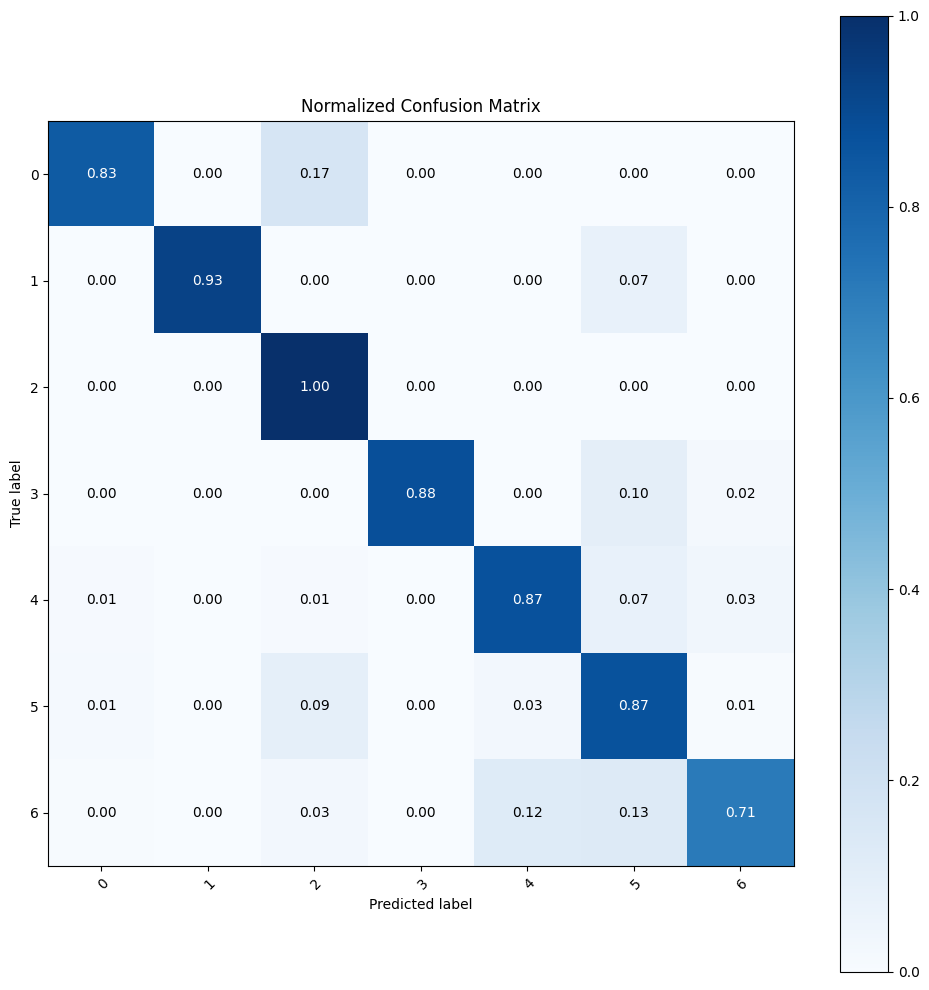

In [ ]:
# plot the confusion matrix
%matplotlib inline
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title='Normalized Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

## Classification classes
- 0 : Bareland
- 1:  Water
- 2:  Others
- 3:  TreeCover
- 4:  BuiltUp
- 5:  Maize
- 6:  Grassland

In [ ]:
# predict again with the tree interpreter to see how much each band contributes to the classification
sample = 100
prediction, bias, contributions = ti.predict(clf, X_test[:sample])
c = np.sum(contributions, axis=0)

In [ ]:
# # plot the contributions
# band_names = ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'NDVI', 'NDWI']

# gdf = gpd.GeoDataFrame(c, columns=classes, index=band_names)
# gdf.style.background_gradient(cmap='viridis')

## Using the Model

### Generate predictions over the full image

Now that we've trained and tested the model over the existing data we can use the trained RandomForestClassifier `clf` over a whole satellite image that covers a larger geospatial location. We can split the job into small tiles to optimize the compute power and potentially do the classification in parallel.

In [ ]:
# in this case, we predict over the entire input image
# (only small portions were used for training)
new_image = raster_file

# specify the output
output_image = op.join(my_root_dir, "classification.tif")

with rasterio.open(new_image, 'r') as src:
    profile = src.profile
    profile.update(
        dtype=rasterio.uint8,
        count=1,
    )
    with rasterio.open(output_image, 'w', **profile) as dst:

        # perform prediction on each small image patch to minimize required memory
        patch_size = 500

        for i in range((src.shape[0] // patch_size) + 1):
            for j in range((src.shape[1] // patch_size) + 1):
                # define the pixels to read (and write) with rasterio windows reading
                window = rasterio.windows.Window(
                    j * patch_size,
                    i * patch_size,
                    # don't read past the image bounds
                    min(patch_size, src.shape[1] - j * patch_size),
                    min(patch_size, src.shape[0] - i * patch_size))

                # read the image into the proper format
                data = src.read(window=window)

                # adding indices if necessary
                img_swp = np.moveaxis(data, 0, 2)
                img_flat = img_swp.reshape(-1, img_swp.shape[-1])

                img_ndvi = band_index(img_flat, 3, 2)
                img_ndwi = band_index(img_flat, 1, 3)

                img_w_ind = np.concatenate([img_flat, img_ndvi, img_ndwi], axis=1)

                # remove no data values, store the indices for later use
                m = np.ma.masked_invalid(img_w_ind)
                to_predict = img_w_ind[~m.mask].reshape(-1, img_w_ind.shape[-1])

                # skip empty inputs
                if not len(to_predict):
                    continue
                # predict
                img_preds = clf.predict(to_predict)

                # add the prediction back to the valid pixels (using only the first band of the mask to decide on validity)
                # makes the assumption that all bands have identical no-data value arrangements
                output = np.zeros(img_flat.shape[0])
                output[~m.mask[:, 0]] = img_preds.flatten()
                # resize to the original image dimensions
                output = output.reshape(*img_swp.shape[:-1])

                # create our final mask
                mask = (~m.mask[:, 0]).reshape(*img_swp.shape[:-1])

                # write to the final files
                dst.write(output.astype(rasterio.uint8), 1, window=window)
                dst.write_mask(mask, window=window)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    4.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    4.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    4.6s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    4.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    8.8s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    9.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 196 tasks      |

### Make a Map


<ipython-input-39-a662324cfcc8>:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  image = image / np.float(imax - imin)


<Axes: >

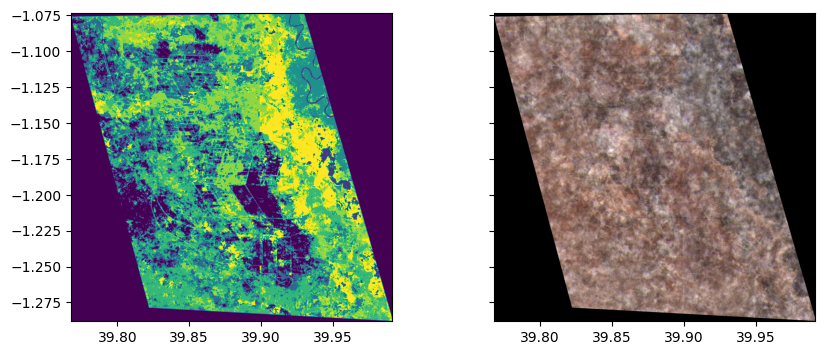

In [ ]:
### Visualize the results
import matplotlib.pyplot as plt
from rasterio.plot import show
%matplotlib inline

# Load the original image
# Load the classification

output_image = '/content/drive/MyDrive/Colab Notebooks/Data/classification.tif'

def linear_rescale(image, in_range=(0, 1), out_range=(1, 255)):
    imin, imax = in_range
    omin, omax = out_range
    image = np.clip(image, imin, imax) - imin
    image = image / np.float(imax - imin)
    return image * (omax - omin) + omin

with rasterio.open(output_image, 'r') as class_raster:
#  show(class_raster)
  classes = class_raster.read()

# Compare side by side
with rasterio.open(raster_file, 'r') as s2_raster:
#  show(s2_raster)
  s2 = s2_raster.read([1,2,3])
  for band in range(s2.shape[0]):
    s2[band] = linear_rescale(
            s2[band],
            in_range=(0, 3000),
            out_range=[0, 255]
        )
  s2 = s2.astype(np.uint8)
  #print(s2.shape)

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 4), sharey=True)
show(classes, transform=class_raster.transform, ax=ax1)
show(s2[[2,1,0], : , :], transform=s2_raster.transform, adjust='linear', ax=ax2)


You can also download and view the results in your favorite GIS application. There's a QGIS [style file](https://drive.google.com/file/d/1JMQWgqIediIRvEyNS3dwSkiELnC2HvVw/view?usp=sharing) in the Shared drive for visualizing.





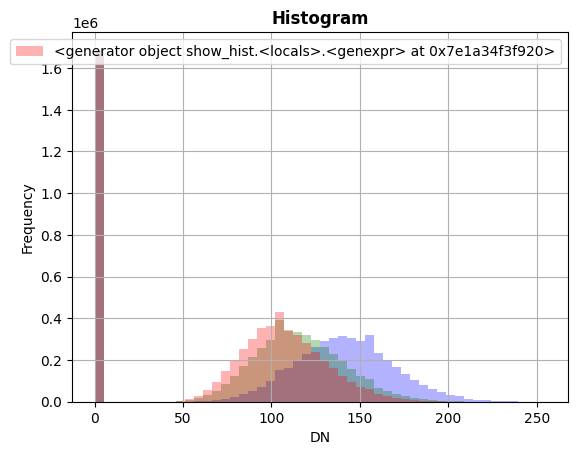

In [ ]:
# Exploring why the imagery is so dark.
# Looks like it will need manual stretching to make a nice image
rasterio.plot.show_hist(s2,
                   bins=50,
                   histtype='stepfilled',
                   lw=0.0,
                   stacked=False,
                   alpha=0.3)